In [34]:
import tensorflow as tf
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import (
    Conv2D,
    Flatten,
    MaxPool2D,
    Dense,
    Input,
    Dropout,
    RandomFlip,
    RandomTranslation,
    RandomZoom,
    RandomRotation,
    GlobalAveragePooling2D,
)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_plot(history):
    '''
    Creates line chart of performance metrics of trained sequential models.

    Input:
        history: Capture the model.fit() into a variable (prefered as history)
    Output:
        Creates 2 line charts displaying model's Training Accuracy, Validation Accuracy, Training Loss, and Validation Loss
        Also prints the final accuracies and losses of the model
    '''
    epochs = range(len(history.history['accuracy']))

    final_acc = history.history['accuracy'][-1]
    final_val_acc = history.history.get('val_accuracy', [None]*len(epochs))[-1]
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history.get('val_loss', [None]*len(epochs))[-1]

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=history.history['accuracy'], label='Training Accuracy', marker='o')
    sns.lineplot(x=epochs, y=history.history.get('val_accuracy', [None]*len(epochs)), label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=history.history['loss'], label='Training Loss', marker='o')
    sns.lineplot(x=epochs, y=history.history.get('val_loss', [None]*len(epochs)), label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Final Training Accuracy: {final_acc:.4f}")
    if final_val_acc is not None:
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Final Training Loss: {final_loss:.4f}")
    if final_val_loss is not None:
        print(f"Final Validation Loss: {final_val_loss:.4f}")


In [3]:
#Loading the dataset
BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)
DIRECTORY = 'datasets/'

#Applying data augementation to prevent overfitting
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

#Training data
train_dataset = image_dataset_from_directory(
    DIRECTORY,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    validation_split = 0.2,
    subset = 'training',
    seed = 42
)

#Validation data
validation_dataset = image_dataset_from_directory(
    DIRECTORY,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

#Memory optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

I0000 00:00:1726138407.234779   34076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726138407.518222   34076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726138407.518276   34076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726138407.526442   34076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726138407.526555   34076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [40]:
#Basic model for reference
base_model = tf.keras.models.Sequential([
    tfl.Input(shape=(160, 160, 3)),
    tfl.Conv2D(filters=15, kernel_size=(3, 3), strides=1, padding='same'),
    tfl.Conv2D(filters=30, kernel_size=(3, 3), strides=1, padding='valid'),
    tfl.MaxPool2D(pool_size=(2, 2), strides=1, padding='same'),
    tfl.Flatten(),
    tfl.Dense(units=1)
    ],
    name = 'base_model'
)
base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 160, 160, 15)   │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 158, 158, 30)   │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 158, 158, 30)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 748920)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │       748,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753,421 (2.87 MB)

 Trainable params: 753,421 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
base_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = base_model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 188ms/step - accuracy: 0.5480 - loss: 557.0901 - val_accuracy: 0.5566 - val_loss: 34.5562
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 186ms/step - accuracy: 0.5592 - loss: 23.0664 - val_accuracy: 0.5614 - val_loss: 34.2671
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accuracy: 0.5589 - loss: 20.1812 - val_accuracy: 0.5630 - val_loss: 36.0059
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 186ms/step - accuracy: 0.5720 - loss: 14.0804 - val_accuracy: 0.5812 - val_loss: 34.2198
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accuracy: 0.5665 - loss: 14.2695 - val_accuracy: 0.5598 - val_loss: 26.5856
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accuracy: 0.5683 - loss: 11.3033 - val_accuracy: 0.5080 - val_loss: 21.3204
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.5679 - loss: 9.2361 - val_accuracy: 0.5598 - val_loss: 22.1502
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accu

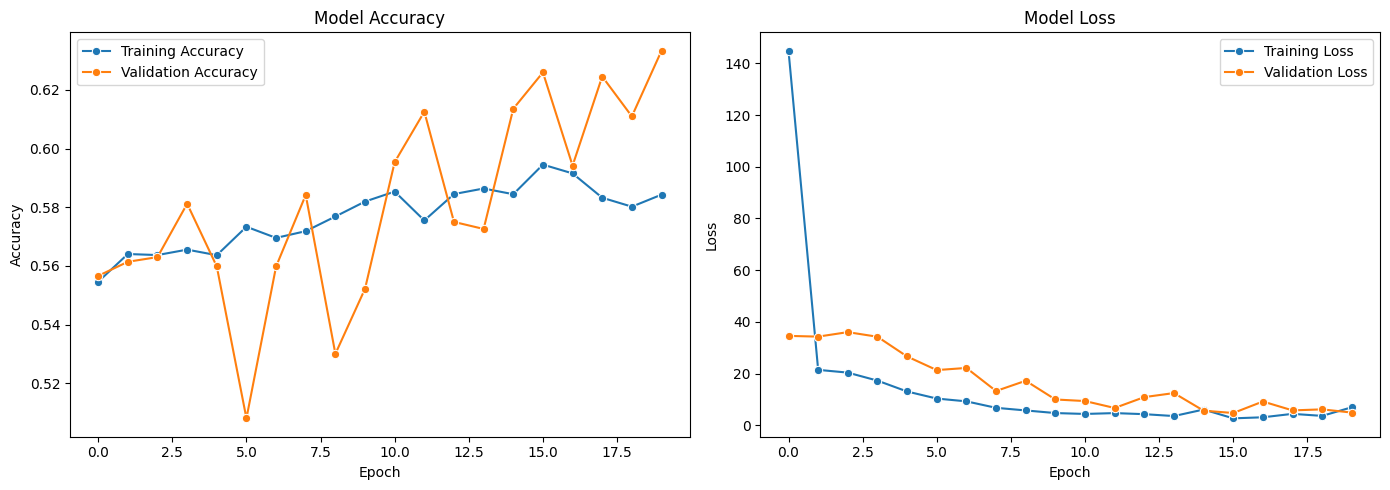

Final Training Accuracy: 0.5843
Final Validation Accuracy: 0.6334
Final Training Loss: 6.9455
Final Validation Loss: 4.8781


In [43]:
model_plot(history)

In [21]:
#Custom made model
model_v1 = tf.keras.models.Sequential(
    [
        Input(shape=(160, 160, 3)),
        Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        Conv2D(
            filters=32, kernel_size=(3, 3), padding="same", activation="relu"
        ),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid'),
    ],
    name="modelv1",
)
model_v1.summary()

Model: "modelv1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,394,721 (51.10 MB)

 Trainable params: 13,394,721 (51.10 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
initial_lr = 0.0001
model_v1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
history = model_v1.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[reduce_lr])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 190ms/step - accuracy: 0.5829 - loss: 1.2319 - val_accuracy: 0.6628 - val_loss: 0.5837 - learning_rate: 1.0000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.6830 - loss: 0.5894 - val_accuracy: 0.7548 - val_loss: 0.5032 - learning_rate: 1.0000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.7389 - loss: 0.5319 - val_accuracy: 0.7808 - val_loss: 0.4602 - learning_rate: 1.0000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.7494 - loss: 0.5131 - val_accuracy: 0.7906 - val_loss: 0.4435 - learning_rate: 1.0000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 185ms/step - accuracy: 0.7795 - loss: 0.4699 - val_accuracy: 0.7986 - val_loss: 0.4409 - learning_rate: 1.0000e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.7891 - loss: 0.4557 - val_accuracy: 0.8220 - val_loss: 0.3926 - learning_rate: 1.0000e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 

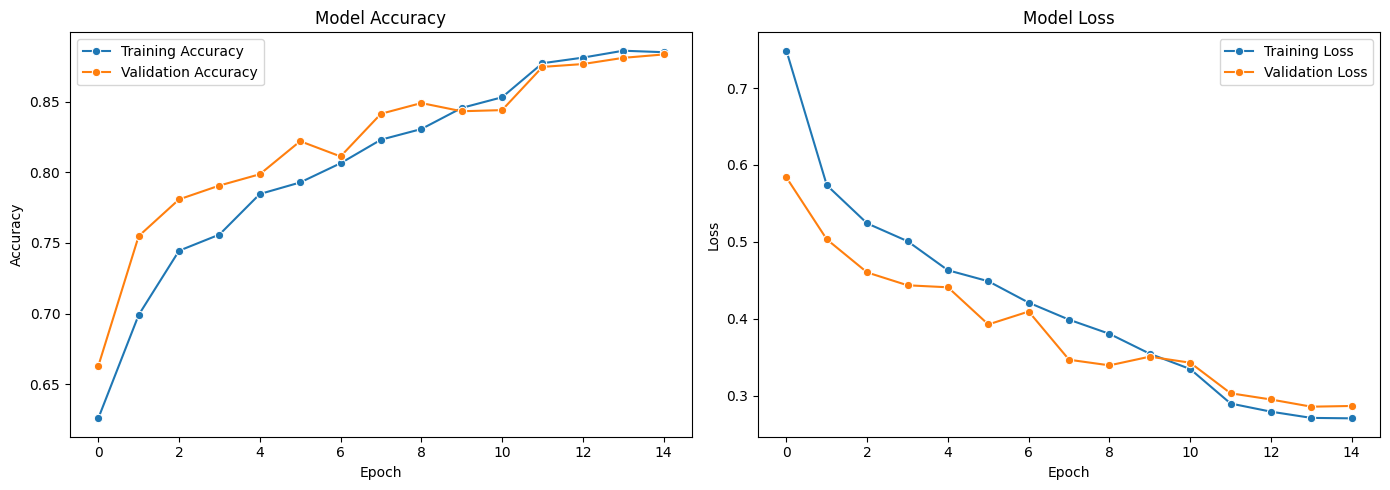

Final Training Accuracy: 0.8850
Final Validation Accuracy: 0.8834
Final Training Loss: 0.2705
Final Validation Loss: 0.2865


In [23]:
model_plot(history)

In [31]:
#MobileNet2 model
mbNet = MobileNetV2(input_shape=(160 ,160, 3), include_top=False, weights='imagenet')
mbNet.trainable = False

model_v2 = tf.keras.models.Sequential([
    mbNet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

In [32]:
model_v2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
history = model_v2.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=15)

Epoch 1/15


625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 191ms/step - accuracy: 0.7058 - loss: 0.5650 - val_accuracy: 0.7816 - val_loss: 0.4642
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step - accuracy: 0.7810 - loss: 0.4677 - val_accuracy: 0.7658 - val_loss: 0.4793
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/step - accuracy: 0.7808 - loss: 0.4614 - val_accuracy: 0.7696 - val_loss: 0.4744
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 191ms/step - accuracy: 0.7846 - loss: 0.4576 - val_accuracy: 0.7572 - val_loss: 0.4924
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.7882 - loss: 0.4468 - val_accuracy: 0.7894 - val_loss: 0.4390
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 187ms/step - accuracy: 0.7822 - loss: 0.4507 - val_accuracy: 0.7926 - val_loss: 0.4432
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.7937 - loss: 0.4371 - val_accuracy: 0.7882 - val_loss: 0.4521
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 118s 188ms/step - accuracy: 0.7965 - loss: 0.43

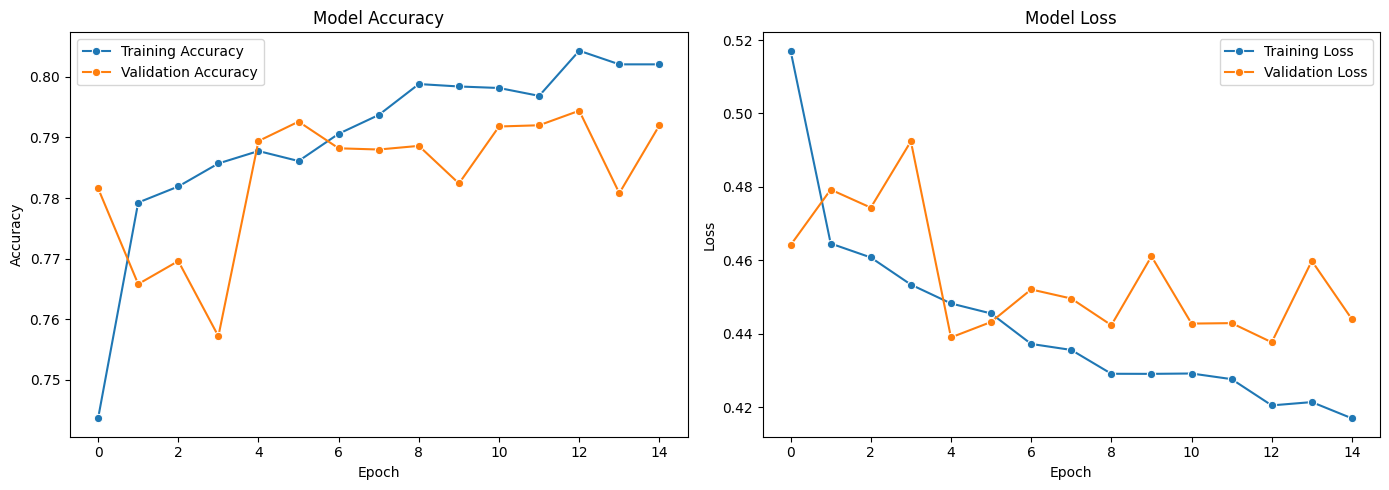

Final Training Accuracy: 0.8020
Final Validation Accuracy: 0.7920
Final Training Loss: 0.4170
Final Validation Loss: 0.4440


In [33]:
model_plot(history)

In [35]:
#Resnet50 model
resnet = ResNet50(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
resnet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 50s 1us/step


In [36]:
resnet_model = tf.keras.models.Sequential([
    resnet,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [38]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)
history = resnet_model.fit(train_dataset, validation_data=validation_dataset, epochs=15, callbacks=reduce_lr)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8542 - loss: 0.3071

2024-09-12 18:50:29.659072: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1691', 168 bytes spill stores, 452 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 205ms/step - accuracy: 0.8543 - loss: 0.3070 - val_accuracy: 0.9552 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 195ms/step - accuracy: 0.9200 - loss: 0.1890 - val_accuracy: 0.9612 - val_loss: 0.0976 - learning_rate: 1.0000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 197ms/step - accuracy: 0.9271 - loss: 0.1741 - val_accuracy: 0.9652 - val_loss: 0.0883 - learning_rate: 1.0000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/step - accuracy: 0.9291 - loss: 0.1683 - val_accuracy: 0.9614 - val_loss: 0.0959 - learning_rate: 1.0000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 193ms/step - accuracy: 0.9361 - loss: 0.1551 - val_accuracy: 0.9622 - val_loss: 0.0932 - learning_rate: 2.0000e-05
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/step - accuracy: 0.9353 - loss: 0.1504 - val_accuracy: 0.9618 - val_loss: 0.0918 - learning_rate: 4.0000e-06
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 120s 192ms/

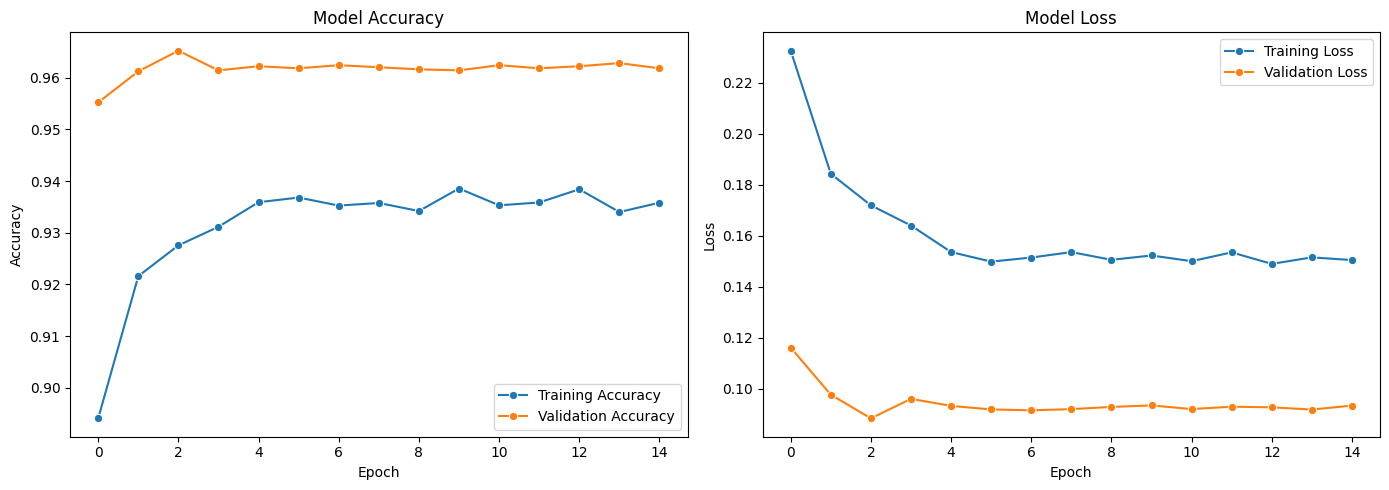

Final Training Accuracy: 0.9358
Final Validation Accuracy: 0.9618
Final Training Loss: 0.1504
Final Validation Loss: 0.0933


In [39]:
model_plot(history)